Please fill in your name and that of your teammate.

You: Hans-Andrea Danuser

Teammate:

# Introduction

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import gym
import IPython
sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Finally. Welcome to the thirteenth, and last, lab. Over the past few weeks you got a whiff of the current state of the art, its complexity, and limitations. Now, there are literally tens of thousands of people trying to push beyond those limitations; of those, maybe 1%-5% are working with Neuroevolution, the number growing drastically in the past 2 years (from an initial few hundreds).

Whether these methods will become the new trend or will be surpassed by something else, the future is in your hands. Goal of this lab is to show you that alternatives are possible, and that Occam's Razor is not easily discounted. Enjoy!

### How to pass the lab?

Below you find the exercise questions. Each question awarding points is numbered and states the number of points like this: **[0pt]**. To answer a question, fill the cell below with your answer (markdown for text, code for implementation). Incorrect or incomplete answers are in principle worth 0 points: to assign partial reward is only up to teacher discretion. Over-complete answers do not award extra points (though they are appreciated and will be kept under consideration). Save your work frequently! (`ctrl+s`)

**You need at least 14 points (out of 21 available) to pass** (66%).

# 1. Fundamentals

#### 1.1 **[1pt]** Why are multimodal problems hard?

Because decending their gradiant deceptively leads to local minima. Exploratory techniques are nessesary to make an algorithm robust to deceptive landscapes. 

#### 1.2 **[2pt]** Define the following: (i) multi-agent algorithm, (ii) black-box optimization, (iii) evolutionary algorithm.

(i): Algorithm that considers multiple solutions at the same time instead of focusing on one.

(ii): Is a familily of methods to maximize or minimize values ofa function without knowing the function itself.

(iii): Is a familiy of multi-agent methods inspired by nature. They create new solutions using randomization, compare them based on their score, then genarte new solutions folowwing the most promising diretion of improvment.

#### 1.3 **[2pt]** Describe in which way the following algorithms differ from an implementation perspective: (i) Genetic Algorithms, (ii) Evolution Strategies, (iii) Genetic Programming.

(i): They  implement the crossover operation (besides mutation), generating a child based on the parents. They operate on binary string making them ideal for descrete optimization.

(ii): They only implement mutation but can adapt it to become invariant to scale and monotonic transformations, which makes the suitable for continous optimizations.

(iii): identical to Genetic algorithms, but its implemented on computational trees, thus searching in the space of computable programms.

#### 1.4 **[1pt]** What is the difference between a $(1+1)$ and a $(2,2)$ population model?

(i): maintains a population of 1 individual: at each generation it creates a new one besed on the old, compares it with the old and chooses the best.

(ii): Maintains 2 individuals, generates 2 more (based on the old), but then selects only 1 (best) to create the new population.

#### 1.5 **[1pt]** Define Neuroevolution.

Neuroevolution is a machine learning technique that uses neural networks as models, but adapt their parametrization (weights) using evolutionary algorithms.

# 2. Evolution Strategy

#### 2.1 **[2pt]** Write a $(1+1)$ Evolution Strategy algorithm in Python as a script (no classes). Run it on the Sphere Minimization problem and plot the sigma and best fitness on a logarithmic scale.

- For the learning rate / step size use the formula $c=1+\frac{1}{d}$ with $d$ number of problem parameters (dimensions).
- You can test it on the Sphere Minimization problem: `lambda x: np.linalg.norm(x)**2` (notice you can drop the squaring term: why?).
- The plot is there to help you debug it.

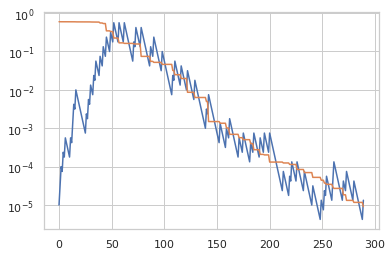

In [12]:
fitness = lambda x: np.linalg.norm(x)
ndims = 3
sigma = 1e-5
x = np.random.randn(ndims)
trg_fit = 1e-5
lrate = 1 + 1 / ndims

fit_x = fitness(x)
sigmas = [sigma]
fits = [fit_x]
while fit_x > trg_fit:

  #new individual
  y = x + sigma * np.random.randn(ndims)
  fit_y = fitness(y)

  #compare fitness
  if fit_y <= fit_x:
    x = y
    fit_x = fit_y
    sigma = sigma * lrate**4 #decrase sigma

  else:
    sigma = sigma/lrate #increase sigma
  
  sigmas.append(sigma)
  fits.append(fit_x)

ax = sns.lineplot(range(len(sigmas)), sigmas)
sns.lineplot(range(len(fits)), fits)
ax.set_yscale('log')


#### 2.2 **[2pt]** Refactor your implementation of a $(1+1)$ Evolution Strategy using a Class.

- This will make it easier to include it later in your Neuroevolution framework.
- Careful: I know it sounds obvious, but double- and triple-check all the `self`s. Also restart the kernel and comment all testing so that you make absolutely sure your code is not capturing global variable definitions through closures.

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

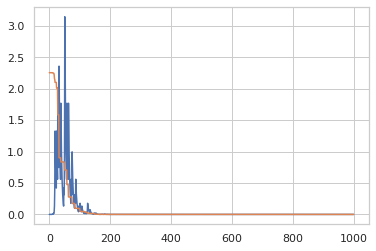

In [19]:
class ES11:
  def __init__(self, ndims, sigma, fitness, lrate=None):
    self.ndims = ndims
    self.sigma = sigma
    self.fitness = fitness
    self.x = np.random.randn(ndims)
    if lrate is None:
      self.lrate = 1 + 1 /ndims
    else:
      self.lrate = lrate
  
    self.fit_x = fitness(self.x)
    self.sigmas = [self.sigma]
    self.fits = [self.fit_x]

  def step(self):
    print('.', end='', flush=True)

    #new individual
    y = self.x + self.sigma * np.random.randn(self.ndims)
    fit_y = self.fitness(y)

    #compare fitness
    if fit_y <= self.fit_x:
      self.x = y
      self.fit_x = fit_y
      self.sigma = self.sigma * self.lrate**4 #decrase sigma

    else:
      self.sigma = self.sigma/self.lrate #increase sigma
  
    self.sigmas.append(self.sigma)
    self.fits.append(self.fit_x)

  def run(self, ngens=1000):
    for ngen in range(ngens):
      self.step()
    return ngen

  def plot(self):
    sigma = self.sigmas
    fit = self.fits

    x_axis = range(len(sigma))
    ax = sns.lineplot(x_axis, sigma)
    x = sns.lineplot(x_axis, fit)

sphere = lambda x: np.linalg.norm(x)

es = ES11(ndims = 3, sigma = 1e-5, fitness = sphere)
es.run()
es.plot()



#### BONUS **[ZERO pt]** Try implementing a $(\mu, \lambda)$-ES. It will perform much better than the $(1+1)$ above.

# 3. Neuroevolution

- To prepare for the experiment, let's refactor and incapsulate some old code into classes.
- Remember that classes are meant to serve you: if you make it too complex you will end up with you serving the class implementation by wasting your time fiddling with it.
- Look at the points given to each question: it should be fairly short and straightforward work, take all the shortcuts you can. Leverage the code you already produced.
- Everything should be made as simple as possible, but not simpler. *(A. Einstein)*

#### 3.1 **[2pt]** Prepare a Neural Network implementation for training with Neuroevolution.

- Reuse the implementation of FFNN from Lab 09 or RNN from Lab 10.
- You need a new method `set_weights()` that takes a numpy array of weights as parameter, checks its size, then uses it to fill all of the network's weight matrices.
- It is useful to define a method or variable `nweights` to hold the number of weights needed to fill up all weight matrices.
- Remember to reset the network's `state` after setting new weights, especially with RNNs! You don't want to carry around old activations. You may want to move the functionality to a new method `reset_state()`.
- Test the new methods in isolation on a randomly generated weights vector before you move on.

In [22]:
class RNN:
  def __init__(self, struct):
    self.struct = struct
    self.nlayers = len(self.struct)
    self.nins, *self.nhids, self.nouts = self.struct

    state_sizes = [inp + rec + 1 for inp, rec in zip(self.struct, self.struct[1:])]
    state_sizes += [self.struct[-1]]

    self.state = [np.empty(size, dtype='float64') for size in state_sizes]
    for s in self.state: 
      s[-1] = 1 # fix bias
    self.reset_state()
    self.inp_idxs = [range(nins) for nins in self.struct]
    self.rec_idxs = [range(orig, orig +nneur) for orig, nneur in zip(self.struct, self.struct[1:])]

    wsizes = [(nrows, ncols) for nrows, ncols in zip(self.struct[1:], state_sizes[:-1])]
    self.nweights = sum(r*c for (r, c) in wsizes)
    self.weights = [np.random.normal(size=ws) for ws in wsizes]
    self.sigma = lambda x: 1/(1+np.exp(-x))

  def act_layer(self, nlay):
    act = self.sigma(self.weights[nlay].dot(self.state[nlay]))
    self.state[nlay+1][self.inp_idxs[nlay+1]] = act
    self.state[nlay][self.rec_idxs[nlay]] = act
  
  def activate(self, inp):
    assert len(inp) == self.nins, f"got input {inp} for len {nins}"
    self.state[0][self.inp_idxs[0]] = inp
    for nlay in range(self.nlayers-1):
      self.act_layer(nlay)
    return self.state[-1]

  def reset_state(self):
    for s in self.state: s[:-1] = 0
    self.state[-1][-1] = 0

  def set_weights(self, weights):
    assert len(weights) == self.nweights
    start = 0
    for nmat in range(len(self.weights)):
      r, c = self.weights[nmat].shape
      end = start + r*c
      self.weights[nmat] = weights[start:end].copy().reshape((r,c))
      start = end

net = RNN([4,3,2,3])
print(net.activate(np.array([1,2,1,2])))
print(net.activate(np.array([1,2,1,2])))
net.set_weights(np.array(np.random.normal(size=net.nweights)))
print(net.activate(np.array([1,2,1,2])))
print(net.activate(np.array([1,2,1,2])))


[0.49109018 0.62773689 0.57429294]
[0.49046201 0.88723321 0.62666266]
[0.47983842 0.65070476 0.57611052]
[0.51577389 0.67767422 0.60285568]


#### 3.2 **[2pt]** Prepare a Control Loop class which initializes on an environment name using the OpenAI Gym. It should offer a method `evaluate()` that takes an array of weights and returns the score of the corresponding RNN policy.

- You can reuse the implementation of the control loop from Lab 12.
- Remember to take the network's input and output sizes from the environment's observation- and action-space. Play with `env.observation_space` and `env.action_space`.
- The environments for the OpenAI Gym have small differences that would make all cases hard to cover. Test your implementation only on Cartpole or Frozen Lake for now, and pass the lab. Playing with others is super interesting, and left for the bonus question.
- Careful taking the Cartpole loop from lab 12: you won't need any per-step interaction, only accumulate the reward and return it at the end. Remember the policy *is* the network, so from the RL perspective you want the full-greedy implementation. The exploration is done through the multiagent implementation.
- I wrote a class that just has an initializer for all parameters, then a function `evaluate` that takes a set of weights and returns the score.
- Test the control loop on a randomly generated weights vector.

In [0]:
class ControlLoop:
  def __init__(self, env_name, net_hids, max_nsteps, env_args=[]):
    self.env_params = [env_name] + env_args

    env = gym.make(*self.env_params)
    ninputs = env.observation_space.shape[0]
    noutputs = env.action_space.n
    self.net = RNN([ninputs, *net_hids, noutputs])
    env.close()

    self.max_nsteps = max_nsteps
  
  def evaluate(self, weights, render=False):
    env = gym.make(*self.env_params)
    self.net.set_weights(weights)
    fitness = 0
    observation = env.reset()
    for nstep in range(self.max_nsteps):
      if render:
        env.render()
        time.sleep(0.05)
      action = np.argmax(self.net.activate(observation))
      observation, reward, done, info = env.step(action)
      fitness -= reward
      if done:
        if render: env.render()
        break
    env.close()
    return fitness

ctrl = ControlLoop('CartPole-v1', [], 200)
ctrl.evaluate(np.array(np.random.normal(size=ctrl.net.nweights)));

#### 3.3 **[3pt]** Solve the OpenAI Gym Cartpole using Neuroevolution for Direct Policy Search. Use only code written by you in the previous questions: the Recurrent Neural Network implementation with the `set_weights()` method, the control loop fitness function, and your $(1+1)$-ES.

- CAREFUL: your ES implementation was tested on the Sphere problem, so it is currently tuned for minimization. The OpenAI Gym on the other hand aims at maximizing a score. The simplest way around this is to go up into the ControlLoop above and return the _negated_ cumulative score as the fitness.
- If everything is correct it should amount to just a few lines of code. But they work on top of the ES, NN and Control you wrote before, so take your time if it gives you problems.
- In the end I'm running 1000 generations with a starting sigma of -.1. The CartPole is limited to 500 steps. Remember that the $(1+1)$-ES is very poor in terms of exploration, since it creates only one individual at each generation, so give it a few tries. On the other hand it is much easier to code (and debug) ;)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

-10.0

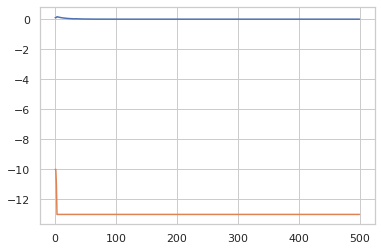

In [28]:
ctrl = ControlLoop('CartPole-v1', [], 500)
es = ES11(ndims=ctrl.net.nweights, sigma = 0.1, fitness = ctrl.evaluate)
es.run(500)
es.plot()
ctrl.evaluate(es.x)

#### 3.4 **[3pt]** Solve the OpenAI Gym Cartpole using Neuroevolution for Direct Policy Search. Use both NN and ES implementations from a library.

- My (biased) advice for the neural network is to go with [`tinynet`](https://github.com/giuse/tinynet) if you can install it (`pipenv install tinynet` locally, but you need to get around `!pip` commands on Colab). Alternatively you can always use Keras, it's just [a bit more complicated](https://keras.io/api/models/model_saving_apis/#setweights-method).
- For the black-box optimization, evolutionary algorithms have not yet been integrated in scikit-learn. You may find some implementation on [GitHub](https://www.google.com/search?q=scikit-learn+evolutionary+algorithms), but it won't likely be better than your implementation above. You can find some state-of-the-art algorithm [if you know where to look](https://github.com/openai/evolution-strategies-starter), but it is still not meant for the general public. The industry standard is still going for the `pycma` package, as instructed [here](https://github.com/CMA-ES/pycma) (or just `pipenv install cma`). The instructions are [here](https://pypi.org/project/cma/), and what you need is basically these lines:
```python
es = cma.CMAEvolutionStrategy(<initial center>, <initial sigma>, <options>)
es.optimize(<per-individual fitness function>)
print(es.result_pretty())
```
The third argument `options` is optional, and is a dictionary of options [like these](https://github.com/CMA-ES/pycma/blob/025ef1fed91c86690a21e9ed81713062d29398ff/cma/evolution_strategy.py#L416). The full documentation (for the brave) can be found [here](http://cma.gforge.inria.fr/apidocs-pycma/cma.evolution_strategy.html#fmin).
- Feel free to reuse the control loop written above -- you may need to refactor it to take a neural network as a parameter. Or rewrite it from scratch ;)
- To make sure everything is working, try printing the action in the fitness after every network activation.
- Also careful with minimization/maximization: many implementations (including `pycma`) by default minimize their fitness, while you want to maximize scores in the OpenAI Gym. Thus the fitness should return the negative of the score.
- For something as simple as a policy on the Cartpole, you don't need recurrent connections, hidden layers or nonlinear activations, and with only 2 neurons and 10 weights already 10-15 generations (option `{'maxiter':10}` should get you a perfect controller. Compare your final setup with the complexity (and runtime) of the RL implementation from last week.
- Feel free to start from a standard normal distribution with a mean of `np.zeros` and sigma `1`. Feel free to verify experimentally the algorithm's robustness to initial conditions.

In [34]:
!pip install tinynet
!pip install cma

import tinynet
import cma
from time import sleep

env = gym.make('CartPole-v1')

nactions = env.action_space.n
ninputs = env.reset().size

hidden = []
net_struct = [ninputs, *hidden, nactions]

net = tinynet.FFNN(net_struct)
print(f"nweights: {net.nweights}")

rseed = np.random.randint(1e10)

def fitness(ind, render=False):
  env.seed(rseed)
  obs = env.reset()
  score = 0
  done = False
  net.set_weights(ind)

  while not done:
    if render:
      env.render()
      sleep(0.01)
    action = net.activate(obs).argmax
    obs, rew, done, info = env.step(action)
    score += rew
    if render: env.render()
  return -score

es = cma.CMAEvolutionStrategy(np.zeros(net.nweights), 1, {'maxiter': 50})
es.optimize(fitness)

best = es.best.get()[0]
best_fit = fitness(best, render = True)
env.close()

print(f"Best Fitness: {best_fit}(best possible score 500)")


nweights: 10
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=459529, Tue Jun 16 12:01:58 2020)


AssertionError: ignored

# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

#### BONUS **[ZERO pt]** Try solving other OpenAI Gym Environments using Neuroevolution.

#### BONUS **[ZERO pt]** Can you address [Atari games](https://gym.openai.com/envs/#atari)? It might be better to use convolutional networks. Just put together your hand-written convolution with your hand-written network, or write the model on Keras and use `set_weights()`. How would you design a network to play the game?

### Final considerations

*Machine Learning is the art of adapting generic solvers to specific problems.*

- *Art*, because you need to create something new. The evaluation of new methods needs to be rigorously scientific, but ML research is first of all a creative process.
- *Generic solvers*, because models need the ability to correspond to a broad set of solutions, based on their parametrization.
- *Adapting*, because you need algorithms to find that ideal parametrization. You can call this learning, searching, updating, feedback, even guessing: anything that adapts the parametrization is fair game, so don't restrict yourself to what is already known.
- *Specific problems*, because you need to remember that the problem is king. Having an amazing method that does not work on your problem has no value for you. The history of ML is chocked full of restrictions, requirements and limitations because we were figuring out what a model is, what learning is, and what can we learn from. We are finally approaching much broader classes of problems, and we need to find novel ways to address them with eyes uncluttered by preconceptions.

Finally, a last remark from my personal side. Success in life necessarily requires both top skill and top luck. Work hard for your skills because those you can improve, but do not take outcomes personally if you are unlucky. And do not envy the lucky unskilled, as eventually they fall the hardest.

Hope this course gave you a new skill. Good luck out there.